In [1]:
from u import *
from ut import *

import os
import torch

from collections import Counter


class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids

%load_ext autoreload
%autoreload 2

In [31]:
wik = Data / 'wikitext-103'
vocab = Counter()
for x in 'train', 'valid', 'test':
    text = (wik / x + '.txt').load()
    tokens = text.split(' ')
    tokens.pop() # remove trailing \n
    vocab.update(tokens)
    print(len(tokens))

103227021
217646
245569


In [39]:
tokens = vocab.most_common()

In [49]:
corpus = Corpus(wik)

In [55]:
data = dict(train=from_torch(corpus.train), valid=from_torch(corpus.valid), test=from_torch(corpus.test))

In [58]:
idx2word = np.array(corpus.dictionary.idx2word)

In [61]:
(Cache.mk() / 'vocab.npy').save(idx2word)

In [66]:
for k in data:
    data[k] = data[k].astype(np.int32)

In [68]:
for k in data:
    ((Cache / 'wikitext-103').mk() / k + '.npy').save(data[k])

In [70]:
(Cache / 'wikitext-103/train.npy').load()

array([ 0,  1,  2, ..., 15,  0,  0], dtype=int32)

In [52]:
len(corpus.dictionary.word2idx)

267735

# Counting number of words

In [2]:
f = (Cache / 'wikitext-103/train.npy').load()

In [12]:
v = (Cache / 'vocab.npy').load()
n_v = len(v)

In [6]:
co = Counter(f)

In [46]:
counts = np.array([co[i] for i in range(n_v)])

In [47]:
counts[0:5000].sum() / counts.sum()

0.7596070606358

In [38]:
counts_s = np.array(sorted(counts, reverse=True))

In [75]:
counts_s[0:3500].sum() / counts_s.sum()

0.8022124749681578

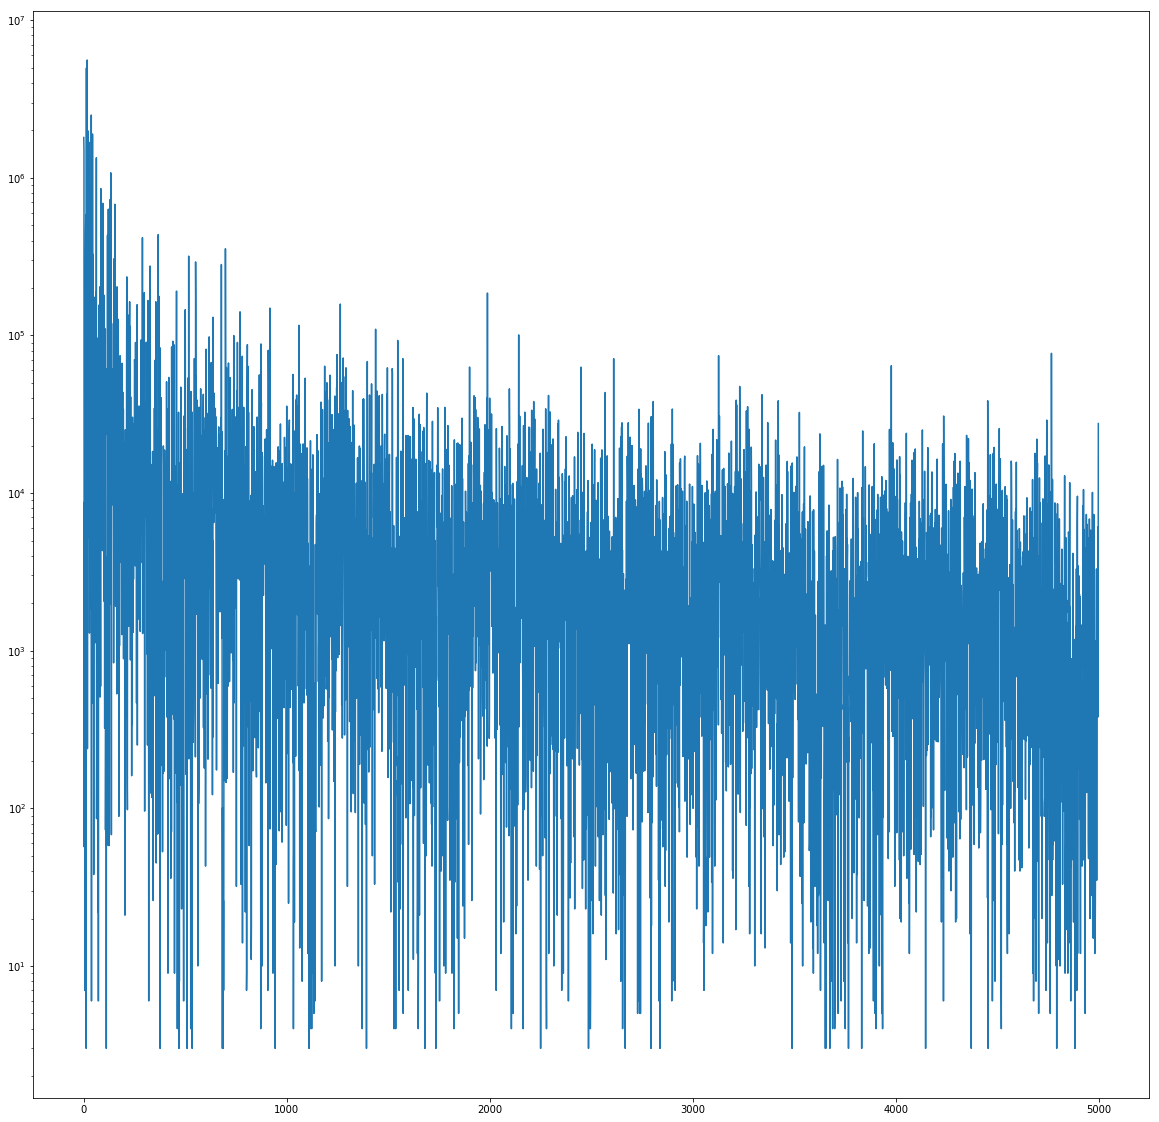

In [28]:
plt.figure(figsize=(20, 20))
ys = counts[:5000]
plt.plot(np.arange(len(ys)), ys)
plt.yscale('log')
plt.show()

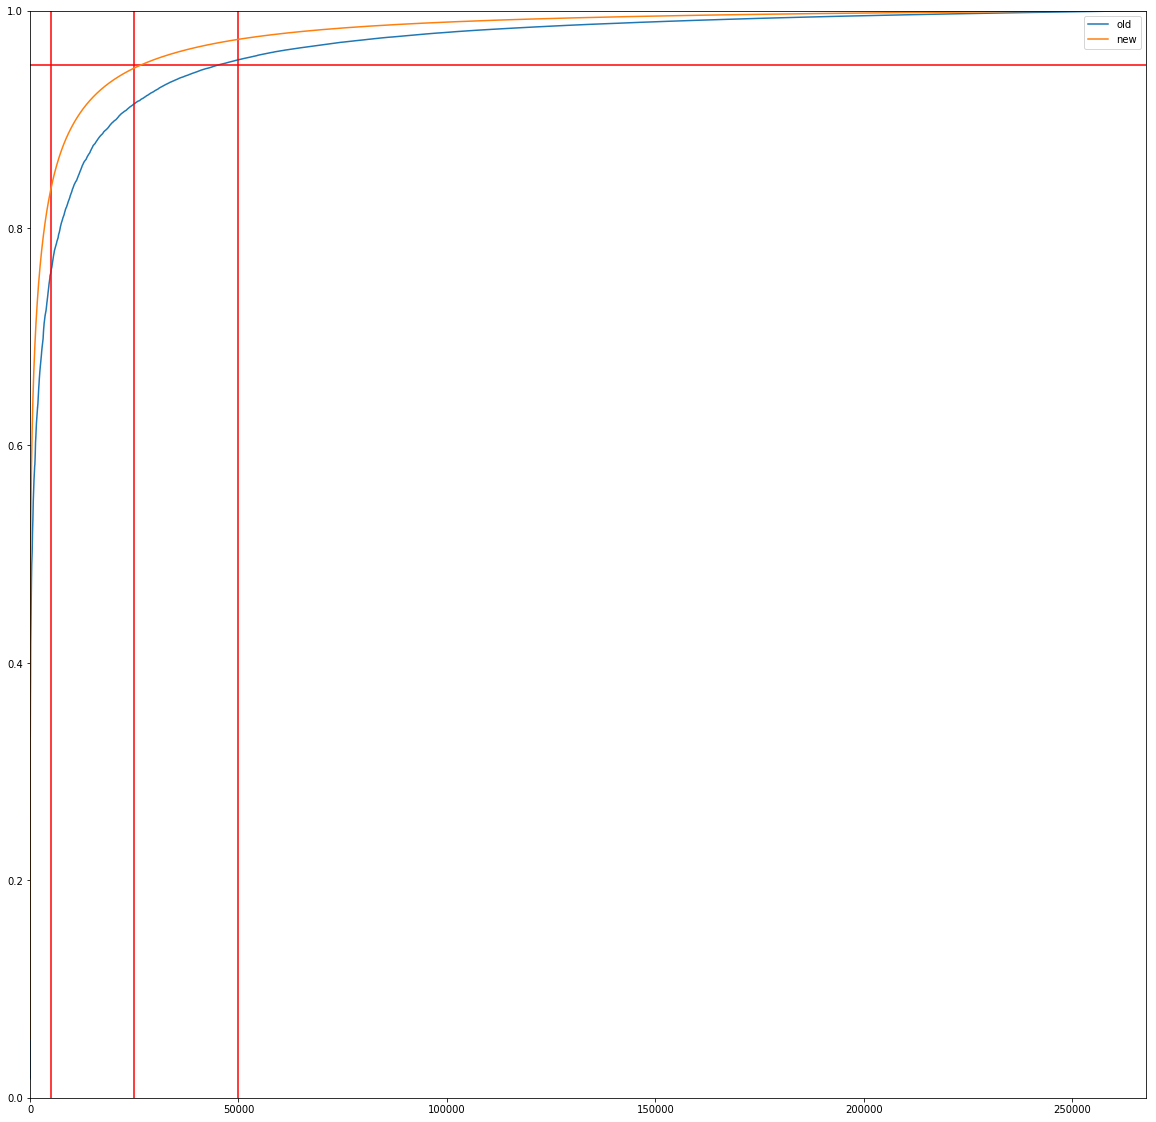

In [73]:
plt.figure(figsize=(20, 20))
ys = np.cumsum(counts)
ys = ys / ys[-1]
plt.plot(np.arange(n_v), ys, label='old')
plt.axvline(5000, color='red')
plt.axvline(25000, color='red')
plt.axvline(50000, color='red')
plt.axhline(0.95, color='red')
plt.xlim([0, 267735])
plt.ylim([0, 1])

ys = np.cumsum(counts_s)
ys = ys / ys[-1]
plt.plot(np.arange(n_v), ys, label='new')
plt.legend()
plt.show()

# Remap vocab according to frequency

In [51]:
order = np.argsort(-counts)

In [60]:
mapping = np.zeros_like(order)
for i, v in enumerate(order):
    mapping[v] = i

In [52]:
new_vocab = v[order]

In [57]:
(Cache.mk() / 'sorted_vocab.npy').save(new_vocab)

In [70]:
for x in 'train', 'valid', 'test':
    tokens = (Cache / 'wikitext-103' / x + '.npy').load()
    new_tokens = mapping[tokens].astype(tokens.dtype)
    (Cache / 'wikitext-103/sorted_' + x + '.npy').save(new_tokens)